In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np

### Clean csv

In [2]:
df = pd.read_csv("imdb_movies.csv") #set dataframe

#get rid of columns such as orig_titlem budget_x, revenue, country
df.drop(df.columns[-6:], axis=1, inplace=True)
#get rid of date
df.drop(df.columns[1], axis=1, inplace=True)
df.head()

,names,score,genre,overview,crew
0,Creed III,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso..."
1,Avatar: The Way of Water,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt..."
2,The Super Mario Bros. Movie,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P..."
3,Mummies,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor..."
4,Supercell,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin..."


In [3]:
# Remove rows with any empty cells
df.dropna(inplace=True)
print(df['genre'].isna().sum())


0


### Preprocess data

In [4]:
nlp = spacy.load("en_core_web_sm")

#each word becomes token
def preprocess(text):
    tokens = [token.text.lower() for token in nlp(text)]
    
    #removes stopwords like ["the", "a", "and"]
    tokens = [token for token in tokens if token not in STOP_WORDS and token not in string.punctuation]
    
    #removes 'ing' like boxing became box
    lemma_tokens = [token.lemma_ for token in nlp(" ".join(tokens))]
    
    #put it into single string
    single_string = " ".join(lemma_tokens)
    
    return single_string

df['preprocessed_synopsis'] = df['overview'].apply(preprocess)
df['preprocessed_genre'] = df['genre'].apply(preprocess)
df.head()

,names,score,genre,overview,crew,preprocessed_synopsis,preprocessed_genre
0,Creed III,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",dominate box world adonis creed thrive career ...,drama action
1,Avatar: The Way of Water,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",set decade event film learn story sully family...,science fiction adventure action
2,The Super Mario Bros. Movie,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",work underground fix water main brooklyn plumb...,animation adventure family fantasy ...
3,Mummies,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",series unfortunate event mummy end present day...,animation comedy family adventure ...
4,Supercell,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",good hearted teenager william live hope follow...,action


In [5]:
assert df['score'].min() >= 0, "Scores must be non-negative."
assert df['score'].max() <= 100, "Scores must not exceed 100."

In [6]:
# Checking for duplicate movie titles in the 'names' column
duplicate_titles = df['names'].duplicated().sum()

# If duplicates exist, we will remove them, keeping the first occurrence
if duplicate_titles > 0:
    df = df.drop_duplicates(subset='names', keep='first')
else:
    df = df.copy()

duplicate_titles, df.shape

(514, (9538, 7))

### Tokenize words

In [7]:
# Tfidf object
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['preprocessed_synopsis'])

### Silhouette Score

<function matplotlib.pyplot.show(close=None, block=None)>

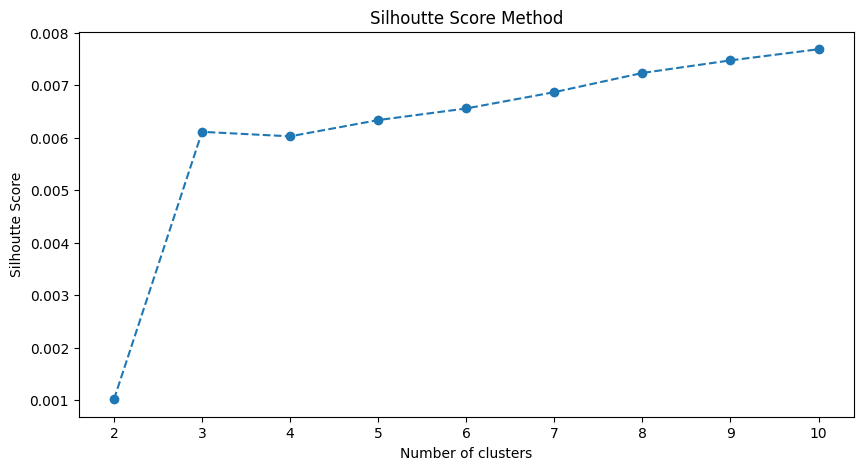

In [8]:
silhouette_scores = []
for i in range(2, 11): #Testing 2 to 10clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10,5))
plt.plot(range(2,11), silhouette_scores, marker='o',linestyle='--')
plt.title('Silhoutte Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte Score')
plt.xticks(range(2,11))
plt.show

### KMeans

In [9]:
# Kmeans object
kmeans = KMeans(n_clusters=4)  # Try diff n_clusters
kmeans.fit(tfidf_matrix)

# Cluster for movies
df['cluster_label'] = kmeans.labels_

### PCA PLOT

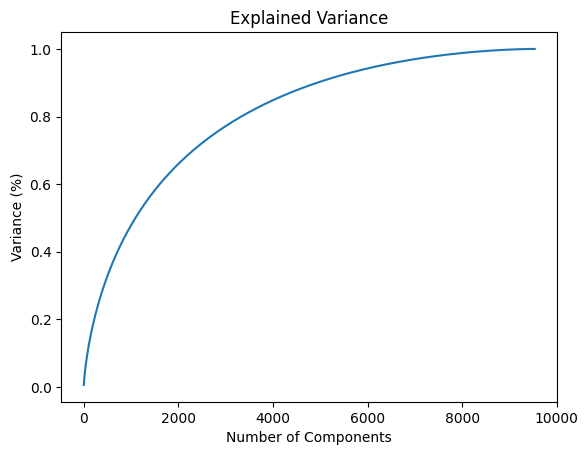

In [10]:
pca = PCA().fit(tfidf_matrix.toarray())

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

### PCA

In [15]:
# reduce dimension
pca = PCA(n_components=3000) #change n_components
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

### LDA

In [16]:
lda = LDA(n_components=10)  # change n_components to see
lda.fit(tfidf_matrix)

LatentDirichletAllocation()

### Movie Recommender Function

In [17]:
def recommend_movies(keyword):
    # Clean up input
    keyword = preprocess(keyword)
    
    # Tokenize w/ tfidf
    keyword_vector = vectorizer.transform([keyword])
    
    # Predict cluster
    cluster = kmeans.predict(keyword_vector)[0]
    cluster_movies = df[df['cluster_label'] == cluster] #['names']
    
    cosine_similarities = cosine_similarity(keyword_vector, tfidf_matrix).flatten()
    
    top_five = cosine_similarities.argsort()[:-6:-1] #top 5 movies
    recommended_movies = df.iloc[top_five][['names', 'score', 'genre', 'overview']] #make sure to add genre scores synopsis
    
    return recommended_movies



In [18]:
recommend_movies('basketball')

,names,score,genre,overview
10090,Above the Rim,69.0,Crime,Story of a promising high school basketball st...
8495,The Way Back,66.0,Drama,"A former basketball all-star, who has lost his..."
2529,Kuroko's Basketball the Movie: Last Game,78.0,Animation,Shortly after the Inter-High of Kagami and Kur...
8200,He Got Game,68.0,Drama,A basketball player's father must try to convi...
9893,Triple Standard,51.0,Drama,A homophobic ex-basketball star is forced to f...
